In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import os
from keras.utils import to_categorical

In [2]:
# need to change directory to your directory


# Convolutional Autoencoder with updating weights

In [5]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

def encoder(input_img):
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

def decoder(encoded):
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return decoded

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# display the weights of the first layer 
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
__________

### - function for changing the weight

In [7]:
layer_num = 1
sigma = 0.01

def change_weight(layer_num, sig):
    
    # get the weight matrix for the first layer
    weights = autoencoder.layers[layer_num].get_weights()[0]
    # get the weight matrix for the bias 
    second = autoencoder.layers[layer_num].get_weights()[1]
    
    # In this example, there are total 3x3 arrays of 16 weights
    # it looks like: 
    
    # 16  16  16
    # 16  16  16
    # 16  16  16
    
    for i in range(len(weights[0])): # for each row 
        one = weights[i] 
        for s in range(len(one)): # for the each arrays of the each row
            two = one[s][0]
            for x in range(len(two)): # for the every weights in the arrays
                # update the weight values by using Gaussian by setting mu = weight, and sigma
                two[x] = np.random.normal(two[x], sig, 1)[0] 
    
    # combine the updated weights with the bias weights
    updated = [weights,second] 
    
    # update the weights in the autoencoder layer
    autoencoder.layers[1].set_weights(updated) 
    

    

# change weight. The arguments are (ith layer , sigma)
change_weight(1,0.01)

In [8]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [9]:
train_y_one_hot = to_categorical(y_train)
test_y_one_hot = to_categorical(y_test)

# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', train_y_one_hot[0])

Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### -Updating weights every epochs

In [11]:
epoch_num = 100
train_loss = []
val_loss = []
acc = []
val_acc = []

def autoencoder_updator(epochs=epoch_num):
    # intial changing weight
    change_weight(1,0.01)
    change_weight(1,0.02)

    # first epoch of fitting autoencoder
    autoencoder.fit(x_train, x_train,
                    epochs=1,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    # save the weight for the first epoch of the model
    autoencoder.save_weights('weight.h5')

    
    # starting with 2nd epoch, the weights will be saved and loaded using for loop
    epoch_in = 2

    # 
    for i in range(epoch_num-1):
        print('Epoch number: %s'%(epoch_in))
    
        autoencoder.load_weights('weight.h5')
    
        # update the weight
        change_weight(1,0.01)
        change_weight(1,0.02)
    
        # fit the model once
        history=autoencoder.fit(x_train, x_train,
                    epochs=1,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    
        # save the model weight
        autoencoder.save_weights('weight.h5')
        
        # store cost
        train_loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        #acc.append(history['acc'])
        #val_acc.append(history['val_acc'])
    
        epoch_in += 1


## Fitting the model

In [ ]:
autoencoder_updator()

In [17]:
#import pandas as pd
#pd.DataFrame({'train_loss':train_loss,'val_loss':val_loss}).to_csv('loss.csv',index=False)

In [ ]:
plt.figure(figsize=(14,8))
plt.plot([i for i in range(0,epoch_num-1)], train_loss, label='train loss')
plt.plot([i for i in range(0,epoch_num-1)], val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss plot with noise')
plt.legend()
plt.savefig('autoencoder_with_noise.png')

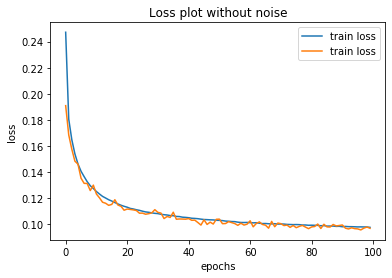

In [20]:
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss plot without noise')
plt.legend()
plt.savefig('autoencoder.png')

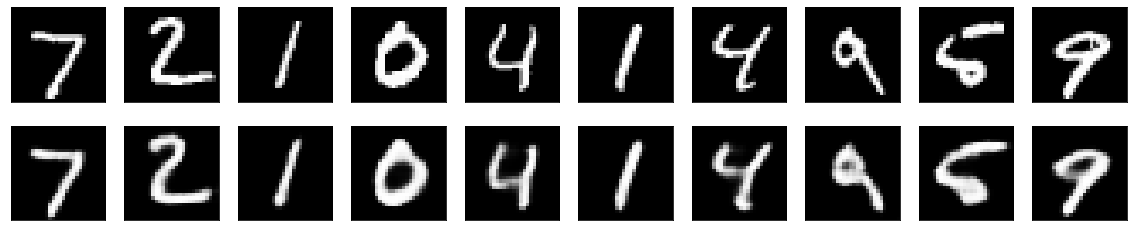

In [47]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.savefig('reconstruction.png')
plt.show()

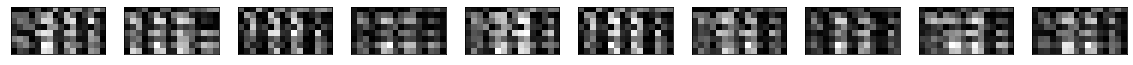

In [48]:
# extracting only encoder and pulling out the encoded imgs
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
import os
os.chdir('/sfs/qumulo/qhome/yl2vq/MSDS/mnistimage')
# encoded representation
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    #plt.imshow(encoded_imgs[i].reshape(28,28))
    plt.imshow(encoded_imgs[i].reshape(16, 8).T) # 128 
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig('1.png')
plt.show()

In [43]:
import os 
os.getcwd()

'/sfs/qumulo/qhome/yl2vq/MSDS'

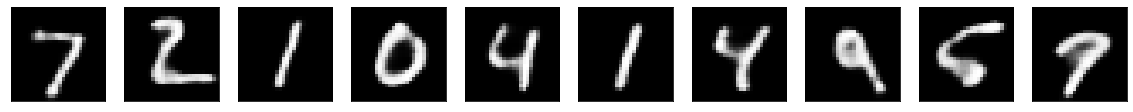

In [45]:
encoded_imgs = autoencoder.predict(x_test)
# encoded representation
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

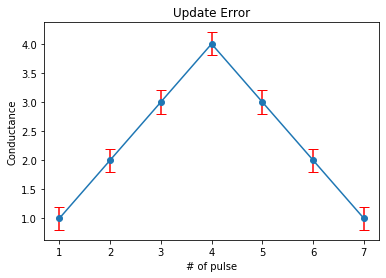

In [16]:
import matplotlib.pyplot as plt 
  
# x axis values 
x = [1,2,3,4,5,6,7] 
# corresponding y axis values 
y = [1,2,3,4,3,2,1] 
  
# plotting the points  
plt.plot(x, y) 
plt.errorbar(x, y, yerr=0.2, fmt='o',ecolor='red',capsize=5);

  
# naming the x axis 
plt.xlabel('# of pulse') 
# naming the y axis 
plt.ylabel('Conductance') 
  
# giving a title to my graph 
plt.title('Update Error') 
  
# function to show the plot 
plt.show() 

Text(0.5, 1.0, 'Read Error')

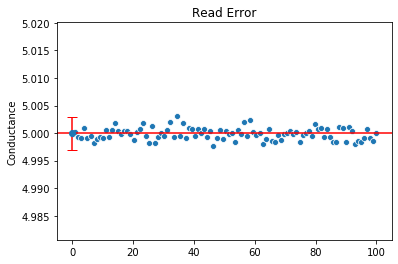

In [31]:
import numpy as np
import seaborn as sns
x = np.linspace(0,100,100)
y = np.random.normal(5,0.001,100)
sns.scatterplot(x,y)
plt.axhline(y=5, color='r', linestyle='-')
plt.errorbar(0, 5, yerr=0.003, fmt='o',ecolor='red',capsize=5)
plt.ylabel('Conductance')
plt.title('Read Error')

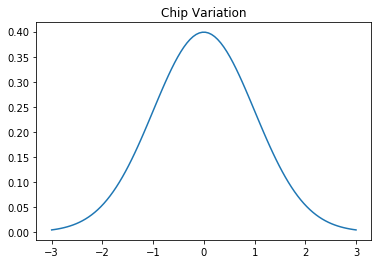

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title('Chip Variation')
plt.show()

# Image classification

In [45]:
# encoder that has same architecture from original autoencoder
def encoder(input_img):
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

# fully connected layers
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

encode = encoder(input_img)
full_model = Model(input_img,fc(encode))


# change the encoder weights to trained encoder weights
for l1,l2 in zip(full_model.layers[:7],autoencoder.layers[0:7]):
    l1.set_weights(l2.get_weights())
    
    
# freeze the encoder layers. We don't want them to be updated
for layer in full_model.layers[0:7]:
    layer.trainable = False

full_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 4, 4, 8)           0         
__________

In [48]:
history2 = full_model.fit(x_train, train_y_one_hot, batch_size=32,epochs=10,verbose=1,validation_data=(x_test, test_y_one_hot))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.3827 - acc: 0.8830 - val_loss: 0.1973 - val_acc: 0.9384
Epoch 2/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.1946 - acc: 0.9383 - val_loss: 0.2242 - val_acc: 0.9239
Epoch 3/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.1617 - acc: 0.9495 - val_loss: 0.1343 - val_acc: 0.9583
Epoch 4/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.1434 - acc: 0.9538 - val_loss: 0.1255 - val_acc: 0.9608
Epoch 5/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.1323 - acc: 0.9571 - val_loss: 0.1156 - val_acc: 0.9633
Epoch 6/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.1232 - acc: 0.9601 - val_loss: 0.1439 - val_acc: 0.9510
Epoch 7/10
60000/60000 [==============================] - 6s 95us/step - loss: 0.1144 - acc: 0.9632 - val_loss: 0.1123 - val_ac

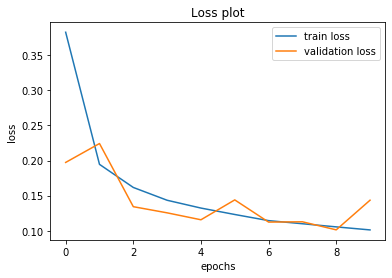

In [54]:
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss plot')
plt.legend()

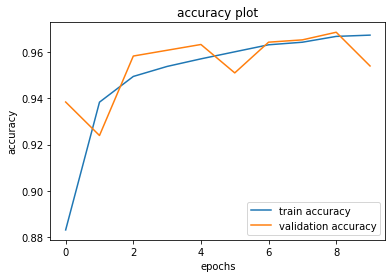

In [58]:
plt.plot(history2.history['acc'], label='train accuracy')
plt.plot(history2.history['val_acc'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy plot')
plt.legend()


In [64]:
import pandas as pd
pd.DataFrame({'val_loss':history2.history['val_loss'],
             'val_accuracy':history2.history['val_acc'],
             'train_loss':history2.history['loss'],
             'train_accuracy':history2.history['acc']}).to_csv('classification.csv',index=False)